In [1]:
import sys
import os
import pathlib
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import json
import gdown
import zipfile

# Uncomment if you haven't installed sred
#if '../src' not in sys.path:
#    sys.path.append('../src')

import sred
import sred.tools.depth_viewer as dv

# Download Kinect v2 Data

Sample data from the CoRBS Dataset.

<https://ieeexplore.ieee.org/abstract/document/7477636>

    @inproceedings{
        wasenmuller2016corbs,
        author={Wasenmüller, Oliver and Meyer, Marcel and Stricker, Didier},
        booktitle={2016 IEEE Winter Conference on Applications of Computer Vision (WACV)},
        title={CoRBS: Comprehensive RGB-D benchmark for SLAM using Kinect v2},
        year={2016},
        pages={1-7},
        doi={10.1109/WACV.2016.7477636}
    }

In [2]:
data_dir = pathlib.Path('CoRBS')
os.makedirs(data_dir, exist_ok=True)

data_sequences = [
    ("H1_raw", "1HFLvbGsOcNAKGHU5lQt4nxCBX2tZxLIP"),
    ("H2_raw", "1Q77ONSPmMdzZ1NBGIbrT7N1wVtTT0n24"),
    ("H3_raw", "1daYgyJW1qUW_0LHNKTniIDduWvG8XHJA"),
    # H4_raw used in the original work but here ommitted due to cloud storage limitations
    ("H5_raw", "1NyCFYMgeJ9VUh6MTL1yPBro8wrAP5QNV")
]

# Download and unzip
delete_zip = True
for name, file_id in data_sequences:
    url = f'https://drive.google.com/uc?id={file_id}&confirm=t'
    zip_path = data_dir / (name + '.zip')
    
    if (data_dir / name).is_dir():
        print(f'\nSequence {name} Already Exists, Skipping.')
        continue
    
    gdown.download(url, str(zip_path), quiet=False)
    # python function may sometimes fail with large files
    # retry with shell command
    if not zip_path.is_file():
        print('\nDownloading through shell...')
        print('From:', url)
        print('To:', zip_path)
        !gdown -O {str(zip_path)} {url}
    
    with zipfile.ZipFile(zip_path, 'r') as archive:
        print('Extracting...')
        archive.extractall(data_dir) # folder inside already has name
    if delete_zip:
        print('Deleting zip...')
        os.remove(zip_path)


Sequence H1_raw Already Exists, Skipping.

Sequence H2_raw Already Exists, Skipping.

Sequence H3_raw Already Exists, Skipping.

Sequence H5_raw Already Exists, Skipping.


# Generate Training Targets

In [3]:
d_dirs = [data_dir / name / 'depth' for name, _ in data_sequences]
rgb_dirs = [data_dir / name / 'rgb' for name, _ in data_sequences]
target_dirs = [data_dir / f'{name}_targets' for name, _ in data_sequences]

cam_params = {
    # intrinsics
    'd_fx': 363.58,
    'd_fy': 363.53,
    'd_cx': 250.32,
    'd_cy': 212.55,
    'rgb_fx': 1054.35,
    'rgb_fy': 1054.51 + -15,
    'rgb_cx': 956.12,
    'rgb_cy': 548.99,
    # extrinsics
    'angle': 0,
    't_x': 290,
    't_y': -10 +10
}

target_gen_params = {
    'strat': 'interGFMM',
    'cleaner_min': 5,
    'cam_params': cam_params
}

In [4]:
target_gen = sred.data.TargetGenerator(target_gen_params)
totals = target_gen.generate(d_dirs, rgb_dirs, target_dirs, exist_ok=True)

print('\nNumber of targets per folder:', totals)

Generating to directory CoRBS\H1_raw_targets
[Directory Already Exists. Skipping]

Generating to directory CoRBS\H2_raw_targets
[Directory Already Exists. Skipping]

Generating to directory CoRBS\H3_raw_targets
[Directory Already Exists. Skipping]

Generating to directory CoRBS\H5_raw_targets
[Directory Already Exists. Skipping]

[All Done]

Number of targets per folder: [1468, 2547, 1236, 1756]


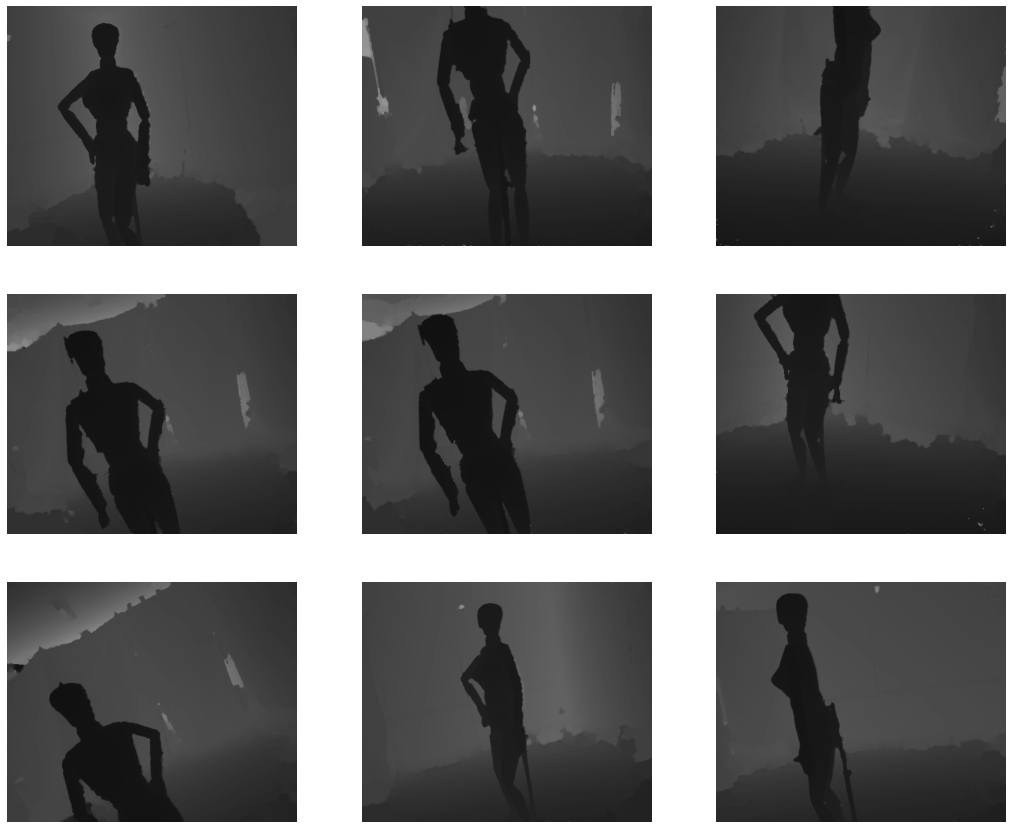

In [5]:
# Preview generated targets

n = 9
cols = 3
rows = n//cols + (n%cols > 1)
img_paths = np.array(sorted(list(target_dirs[0].glob('*.png'))))
np.random.seed(12345)
indices = np.random.randint(len(img_paths), size=n)

plt.figure(figsize=(6*cols, 5*rows))
for i, img_path in enumerate(img_paths[indices]):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(sred.utils.read_img(img_path), cmap='gray', vmin=0, vmax=np.iinfo('uint16').max)
    plt.axis('off')

plt.show()

# Build Dataset Objects

In [6]:
batch_size = 4 #16

train_ds, val_ds, test_ds = sred.data.build_all_datasets(
    d_dirs,
    target_dirs,
    batch_size=batch_size,
    val_split = 0.1,
    test_split = 0.04
)

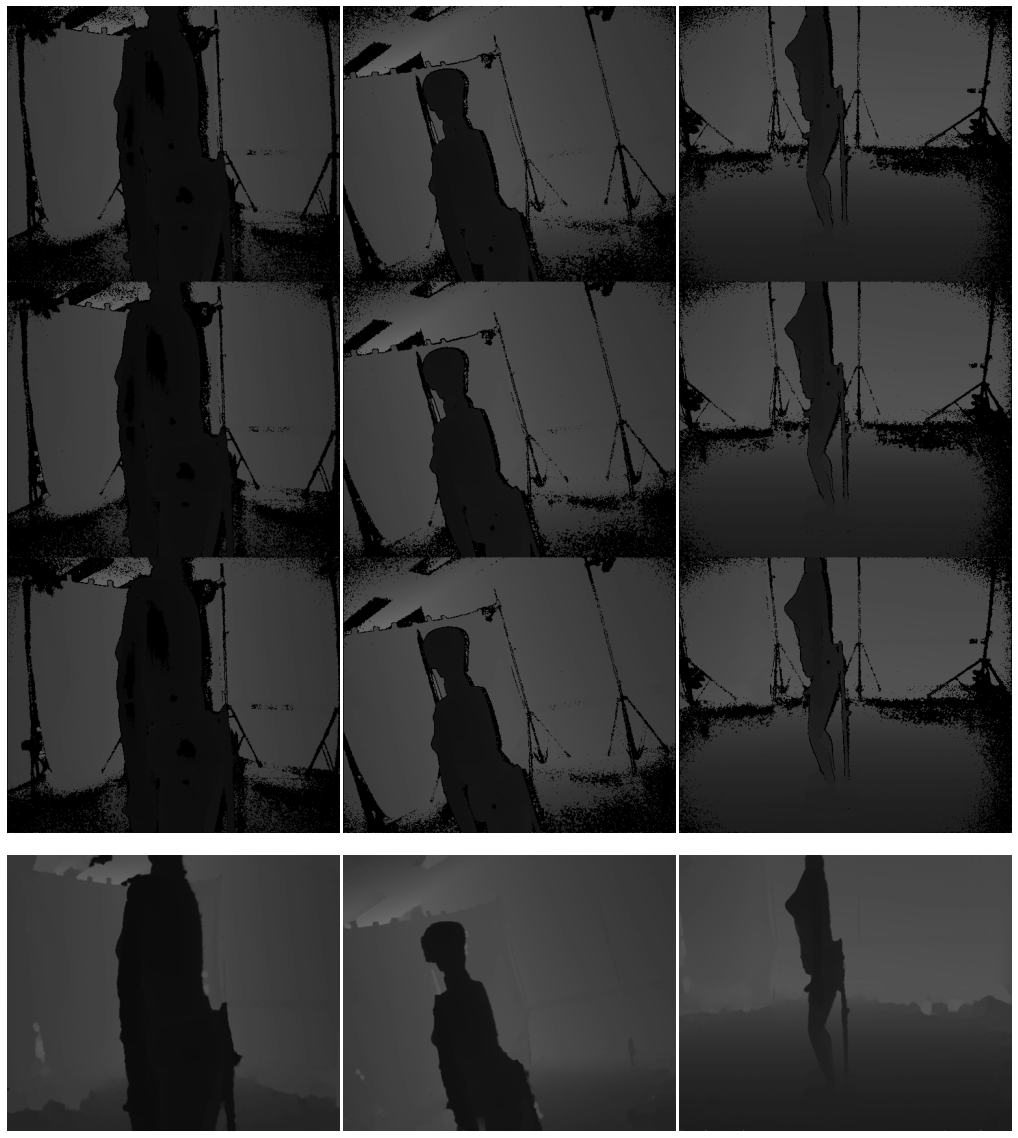

In [7]:
n = 3
fig, ax = plt.subplots(2, n, figsize=(18, 21),
                        gridspec_kw={'height_ratios': [3,1], 'wspace': 0.01, 'hspace': 0.01})

input_batch, target_batch = next(iter(train_ds.take(1)))
for i, (input_img, target_img) in enumerate(zip(input_batch[:n], target_batch[:n])):
    ax[0, i].imshow(tf.concat([input_img[:,:,i] for i in range(input_img.shape[-1])], axis=0), cmap='gray', vmin=0, vmax=1)
    ax[0, i].set_axis_off()
    ax[1, i].imshow(target_img, cmap='gray', vmin=0, vmax=1)
    ax[1, i].set_axis_off()

plt.show()

# Define Model

In [8]:
# Find data shapes
in_sample, tg_sample = next(iter(train_ds.take(1)))
frame_shape = tuple(tg_sample.shape[1:])
input_frames = in_sample.shape[-1] // frame_shape[-1]

# Create Model
model = sred.SReDModel(frame_shape, input_frames, residual=-1)
model.default_compile()
model.summary()

# Prepare output directory
output_dir = pathlib.Path('out')
os.makedirs(output_dir, exist_ok=True)

# Save initial weights
initial_weights_path = output_dir / "initial-weights.h5"
model.save_weights(initial_weights_path)

Model: "s_re_d_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 first_block (FirstBlock)    (None, 424, 512, 32)      10144     
                                                                 
 down_block (DownBlock)      (None, 212, 256, 32)      18496     
                                                                 
 down_block_1 (DownBlock)    (None, 106, 128, 48)      34656     
                                                                 
 down_block_2 (DownBlock)    (None, 53, 64, 48)        41568     
                                                                 
 down_block_3 (DownBlock)    (None, 27, 32, 64)        64640     
                                                                 
 down_block_4 (DownBlock)    (None, 14, 16, 128)       221440    
                                                                 
 up_block (UpBlock)          (None, 27, 32, 128)      

# Train

In [9]:
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
epochs = 100
steps_per_epoch = 200

model.load_weights(initial_weights_path)

res = model.default_fit(
    train_ds,
    epochs,
    steps_per_epoch,
    validation_data = val_ds,
    output_dir = output_dir
)

print(f"\nTotal time:",
    f"{res['time']/3600:.0f}h" +
    f"{res['time']%3600/60:.0f}m" +
    f"{res['time']%3600%60:.2f}")

if res['best_checkpoint_path'] is not None:
    print('\nSaved to:', res['best_checkpoint_path'].parent)

Epoch 1/100
200/200 [==============================] - 339s 2s/step - loss: 0.0167 - val_loss: 0.0092 - lr: 0.0010
Epoch 2/100
200/200 [==============================] - 350s 2s/step - loss: 0.0094 - val_loss: 0.0083 - lr: 0.0010
Epoch 3/100
200/200 [==============================] - 353s 2s/step - loss: 0.0079 - val_loss: 0.0068 - lr: 0.0010
Epoch 4/100
200/200 [==============================] - 353s 2s/step - loss: 0.0070 - val_loss: 0.0064 - lr: 0.0010
Epoch 5/100
200/200 [==============================] - 357s 2s/step - loss: 0.0065 - val_loss: 0.0058 - lr: 0.0010
Epoch 6/100
200/200 [==============================] - 367s 2s/step - loss: 0.0061 - val_loss: 0.0057 - lr: 0.0010
Epoch 7/100
200/200 [==============================] - 371s 2s/step - loss: 0.0059 - val_loss: 0.0056 - lr: 0.0010
Epoch 8/100
200/200 [==============================] - 365s 2s/step - loss: 0.0054 - val_loss: 0.0052 - lr: 0.0010
Epoch 9/100
200/200 [==============================] - 356s 2s/step - loss: 0.00

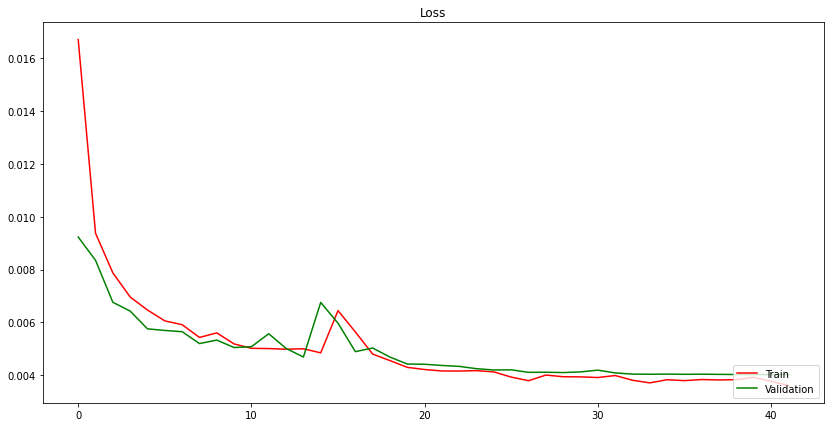

In [11]:
plt.figure(figsize=(14,7))
plt.title('Loss')
plt.plot(res['history'].history['loss'], '-r', label='Train')
plt.plot(res['history'].history['val_loss'], '-g', label='Validation')
plt.legend(loc=4)
plt.show()

# Test

In [12]:
# Test prediction one image at a time

model.load_weights(res['best_checkpoint_path'])

store_size = 20
predictions = []
start_time = time.time()
test_size = 0
for tensor_in in test_ds:
    pred = model.predict(tensor_in)
    test_size += 1
    if len(predictions) < store_size:
        predictions += [pred]
avg_test_time = (time.time() - start_time) / test_size

print(f'Predictions Done [{test_size}]')
print('Prediction shape:', predictions[0].shape)
print(f'Avg time-per-pred: {avg_test_time*1000:.1f}ms')

Predictions Done [280]
Prediction shape: (1, 424, 512, 1)
Avg time-per-pred: 146.3ms


In [13]:
# Test prediction whole test dataset at once

model.load_weights(res['best_checkpoint_path'])

start_time = time.time()
model.predict(test_ds)
avg_test_time = (time.time() - start_time) / test_size

print(f'Avg time-per-pred: {avg_test_time*1000:.1f}ms')

Avg time-per-pred: 97.0ms


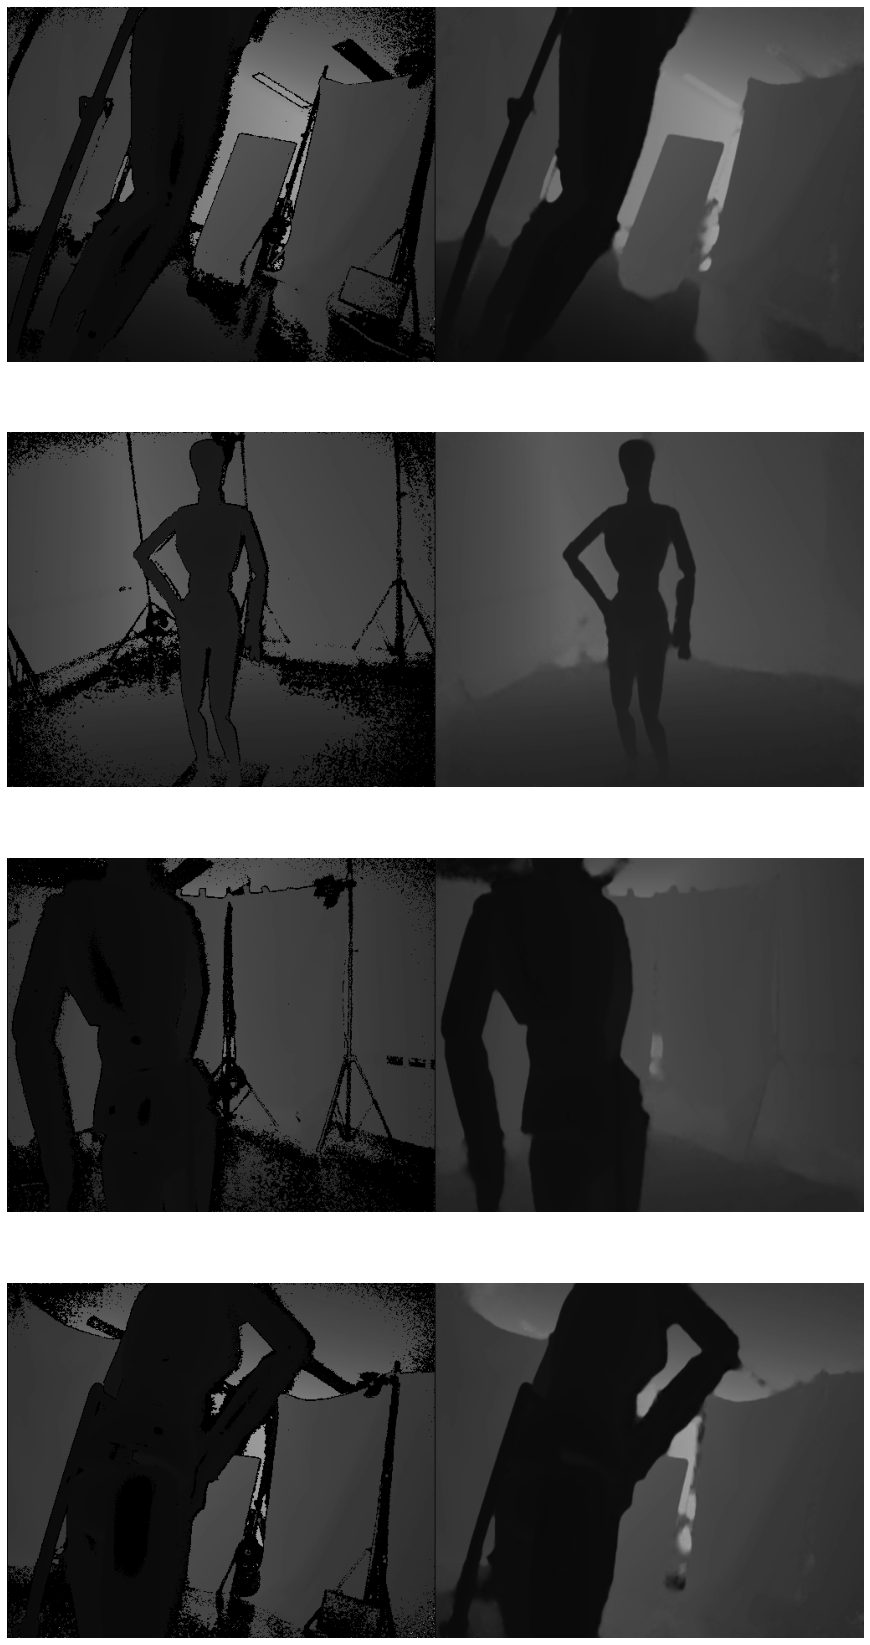

In [14]:
n = 4
skip = 4
plt.figure(figsize=(20, 30))
for i, (tensor_in, np_pred) in enumerate(zip(test_ds.skip(skip).take(n), predictions[skip:skip+n])):
    merged = np.concatenate((tensor_in.numpy()[0,...,-1:], np_pred[0,...]), axis=1)
    plt.subplot(4, 1, i + 1)
    plt.imshow(merged, cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
plt.show()

In [15]:
dv.run_gui({
    'orinigal': [sred.utils.denormalize_frame(tensor_in[0,...,-1]) for tensor_in in test_ds.take(store_size)],
    'denoised': [sred.utils.denormalize_frame(pred) for pred in predictions]
})

# Evaluate

In [16]:
model.load_weights(res['best_checkpoint_path'])

verbose = False

n = 0
vals = []
for tensor_in in test_ds:
    pred = model.predict(tensor_in)
    n += 1
    val = sred.utils.nmid(
        sred.utils.denormalize_frame(tensor_in[0,...,-1]),
        sred.utils.denormalize_frame(pred))
    if verbose: print(val)
    if not np.isnan(val):
        vals += [val]

val_mean = float(np.mean(vals))

if res['best_checkpoint_path'] is not None:
    metric_path = res['best_checkpoint_path'].parent / 'nmid.json'
    with open(metric_path, 'w') as f:
        json.dump({'all': vals, 'mean': val_mean}, f)

print("Avg NMID:", val_mean)

Avg NMID: 0.7170923541962902


In [17]:
# Build dataset of sequential frames for temporal evaluation

test_ds_seq = sred.data.build_test_dataset(
    [data_dir / 'H3_raw/depth'],
    items=(-2,-1,0),
    deep_shuffle=False
)

In [18]:
model.load_weights(res['best_checkpoint_path'])

temp_means = []
temp_vars = []
prev = None
for tensor_in in test_ds_seq:
    if prev is None:
        prev = sred.utils.denormalize_frame(model.predict(tensor_in))
        continue
    curr = sred.utils.denormalize_frame(model.predict(tensor_in))
    mean, var = sred.utils.temporal_diff(prev, curr)
    temp_means += [mean]
    temp_vars += [var]
    prev = curr

temp_means_mean = float(np.mean(temp_means))
temp_vars_mean = float(np.mean(temp_vars))

if res['best_checkpoint_path'] is not None:
    metric_path = res['best_checkpoint_path'].parent / 'temporal_diff.json'
    with open(metric_path, 'w') as f:
        json.dump({
            'all_means': temp_means,
            'all_vars': temp_vars,
            'mean_of_means': temp_means_mean,
            'mean_of_vars': temp_vars_mean
        }, f)

print("Avg Temporal Mean:", temp_means_mean)
print("Avg Temporal Variance:", temp_vars_mean)

Avg Temporal Mean: 0.8197048507502767
Avg Temporal Variance: 1358656.438331783
